In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
# import pyspark.sql.functions as func
# from pyspark.sql.functions import countDistinct
# sc.stop()
# from pyspark.sql import SQLContext
# conf = SparkConf().setAppName("App")
# conf = (conf.set('spark.driver.memory', '60G').set("spark.yarn.executor.memoryOverhead", '4096'))
# sc =SparkContext(conf=conf)
# sqlContext = SQLContext(sc)


In [80]:
#reading in sticker type data
feature_data = spark.read.parquet("gs://ds-url-catag/Stickers/stick_statistics/sticker_download/derived_features/")


In [81]:
# #sampling of the data 
# from pyspark.sql import functions as F
# from pyspark.sql.window import Window

# feature_data = feature_data.withColumn("row_number", F.row_number().over(Window.orderBy('user_id_n')))
# feature_data = feature_data.withColumn("by_20k",lit(100))
# feature_data = feature_data.withColumn("modulo",feature_data.row_number%feature_data.by_20k)
# test_data = feature_data.where(col('modulo') == 0)

#write the sample data to a file 
feature_data.limit(50000).write.mode('overwrite').parquet("gs://ds-url-catag/clustering/clust_test_data")

#reading in the sample data 
feature_test = sqlContext.read.parquet("gs://ds-url-catag/clustering/clust_test_data/")

In [82]:
#convert pyspark to pandas dataframe
import pandas as pd
feature_data_df  = feature_test.toPandas()

#checking size of dataframe
print 'Size of the dataframe: {}'.format(feature_data_df.shape)

Size of the dataframe: (50000, 9)


In [83]:
#logarithmic transformation of two different variables
import numpy as np
feature_data_df['log_noofdays']=np.log10(1+feature_data_df.numofdays)
feature_data_df['log_avg_con_days']=np.log10(1+feature_data_df.avg_con_days)
feature_data_df['log_sticker_packs_download']=np.log10(1+feature_data_df.sticker_packs_download)
feature_data_df['log_distinct_sticker_packs_download']=np.log10(1+feature_data_df.distinct_sticker_packs_download)
feature_data_df['log_sum_paid']=np.log10(1+feature_data_df.sum_paid)
feature_data_df['log_sum_free']=np.log10(1+feature_data_df.sum_free)
feature_data_df['log_sum_subs']=np.log10(1+feature_data_df.sum_subs)
feature_data_df['log_sum_discont']=np.log10(1+feature_data_df.sum_discont)

In [84]:
#computing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_data_df[['log_noofdays','log_avg_con_days','log_sticker_packs_download','log_distinct_sticker_packs_download','log_sum_paid','log_sum_free','log_sum_subs','log_sum_discont']].values)

feature_data_df['pca-one'] = pca_result[:,0]
feature_data_df['pca-two'] = pca_result[:,1] 
feature_data_df['pca-three'] = pca_result[:,2]

print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)


Explained variation per principal component: [0.84962038 0.06775006 0.038769  ]


In [85]:
import numpy as np
rndperm = np.random.permutation(feature_data_df.shape[0])

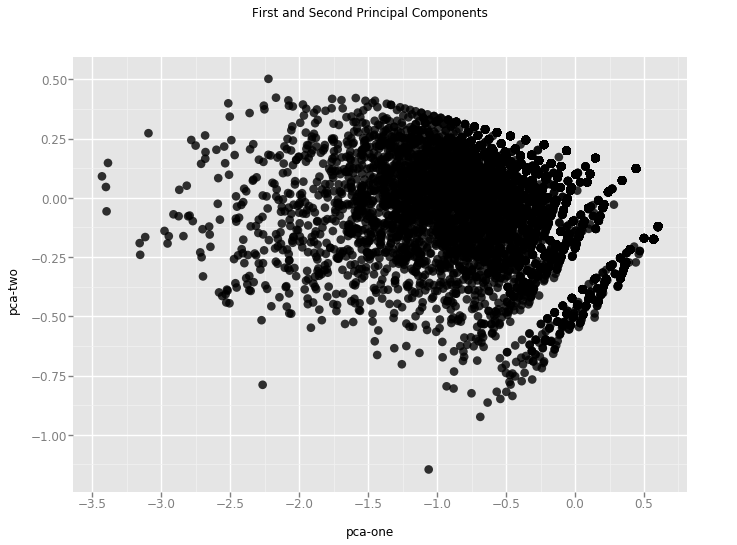

<ggplot: (8737478824657)>


In [86]:
from ggplot import *
chart = ggplot(feature_data_df.loc[rndperm[:20000],:], aes(x='pca-one', y='pca-two') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components")
print chart

In [88]:
intermediate_data = feature_data_df[['pca-one','pca-two','pca-three']]

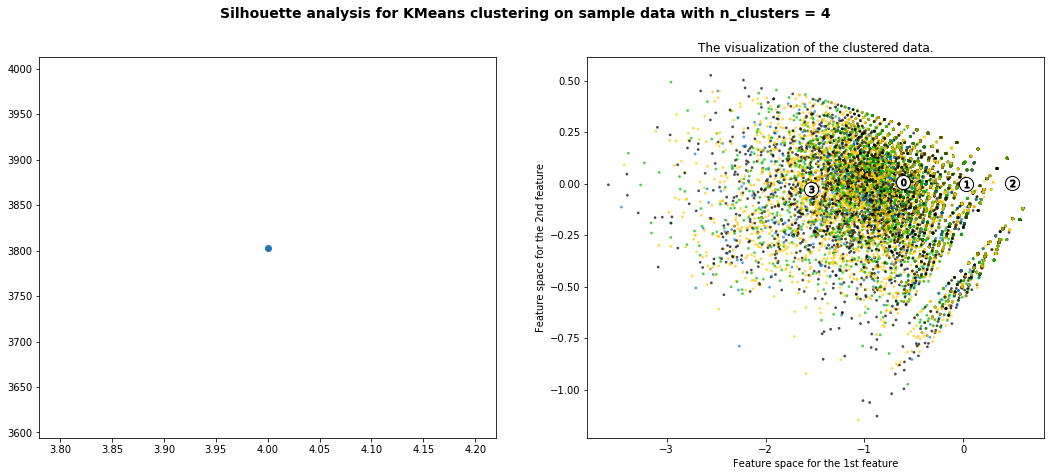

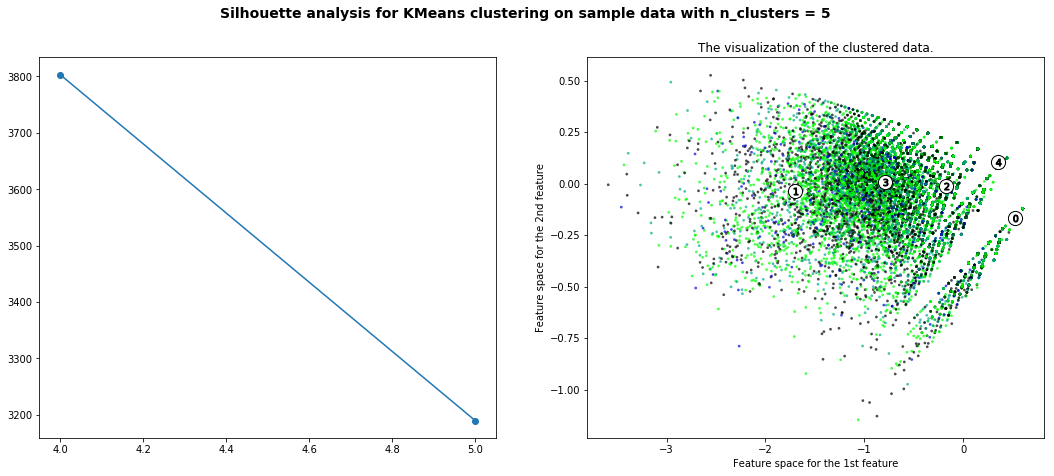

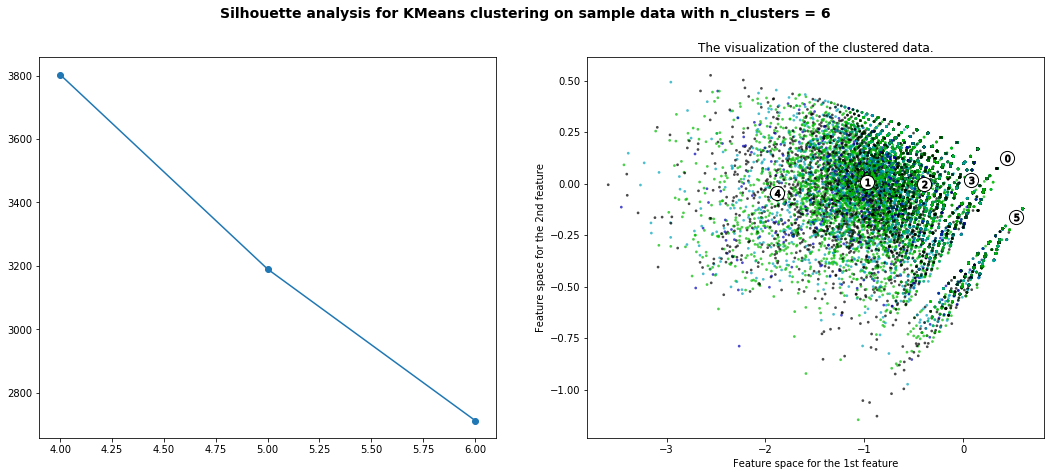

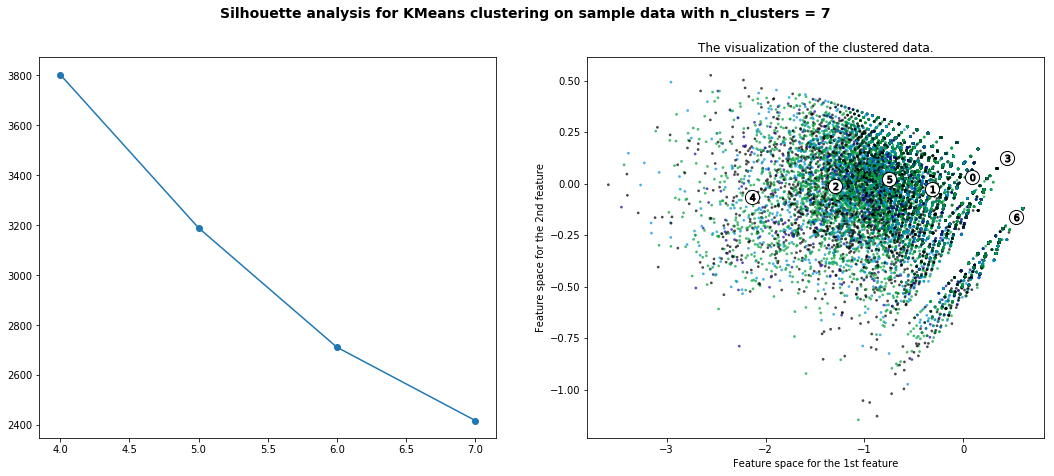

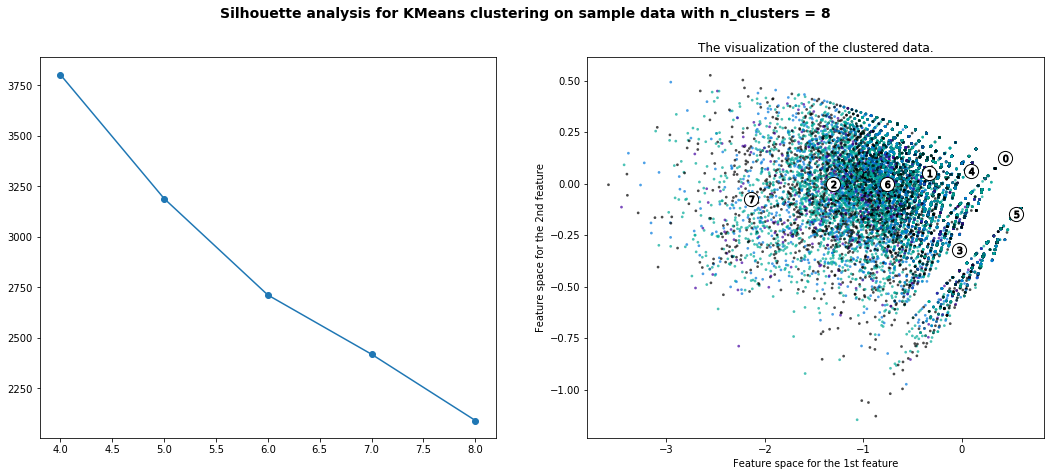

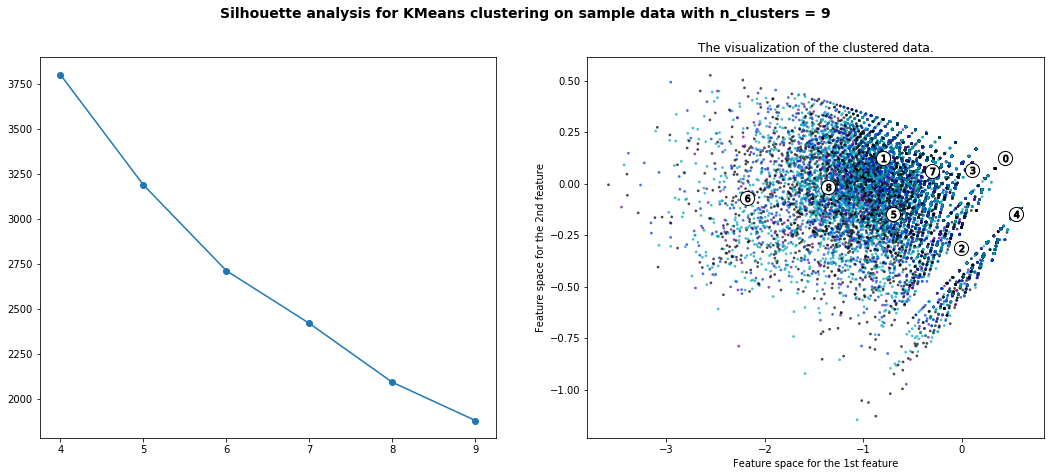

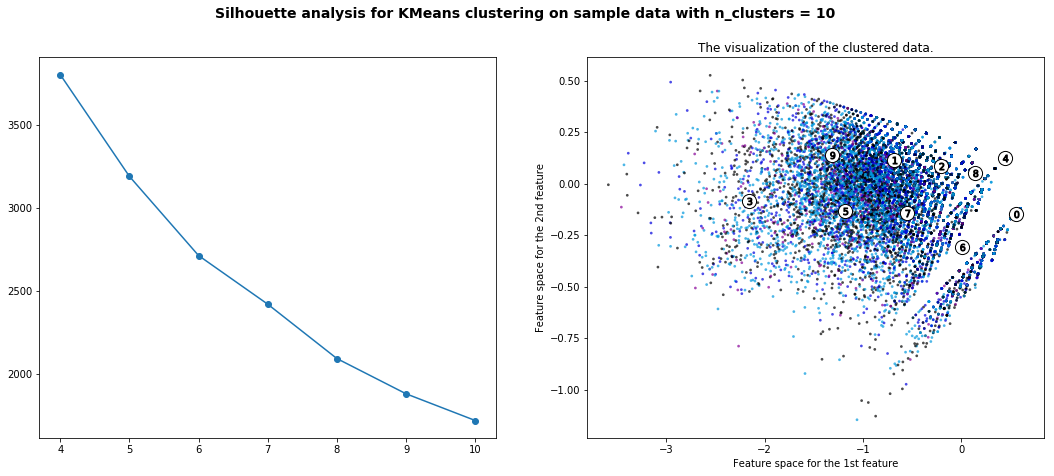

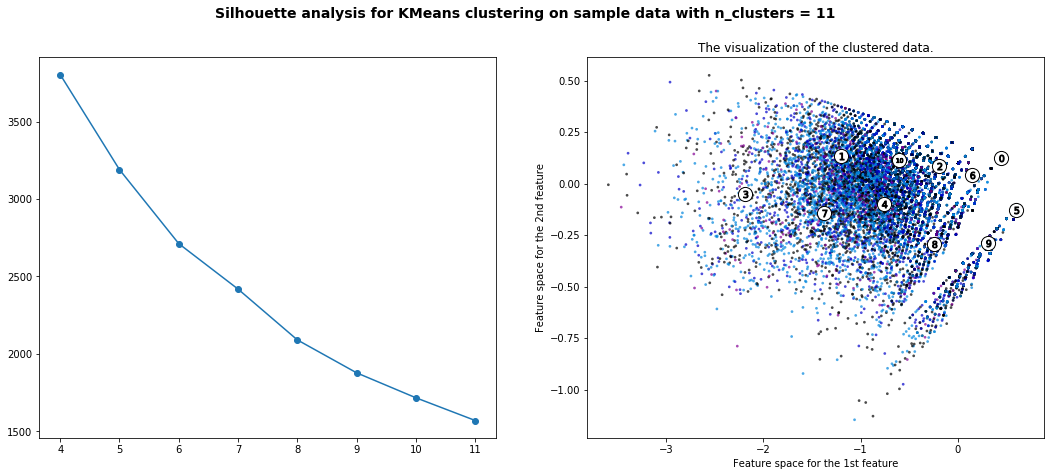

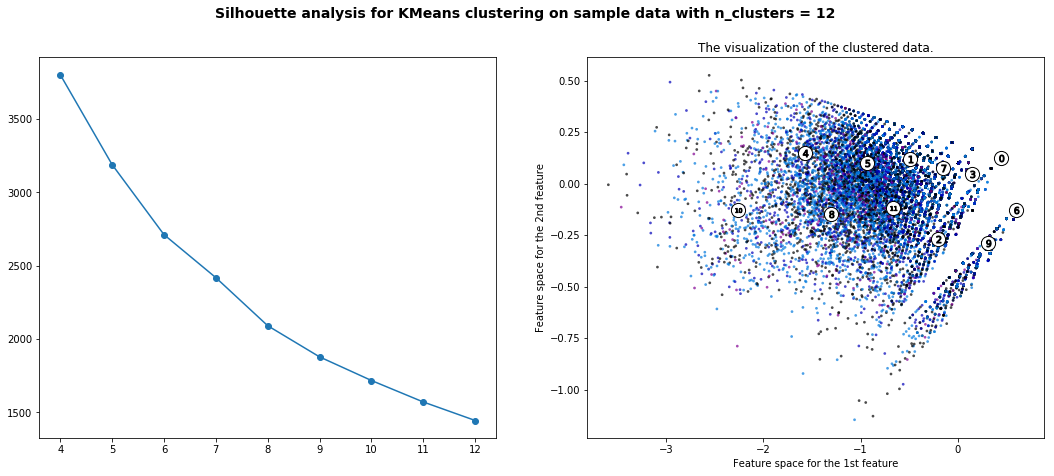

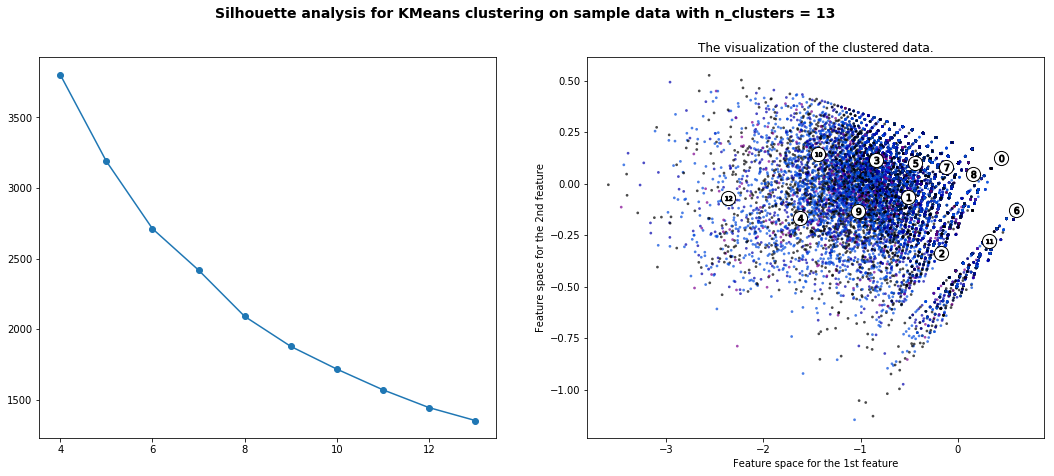

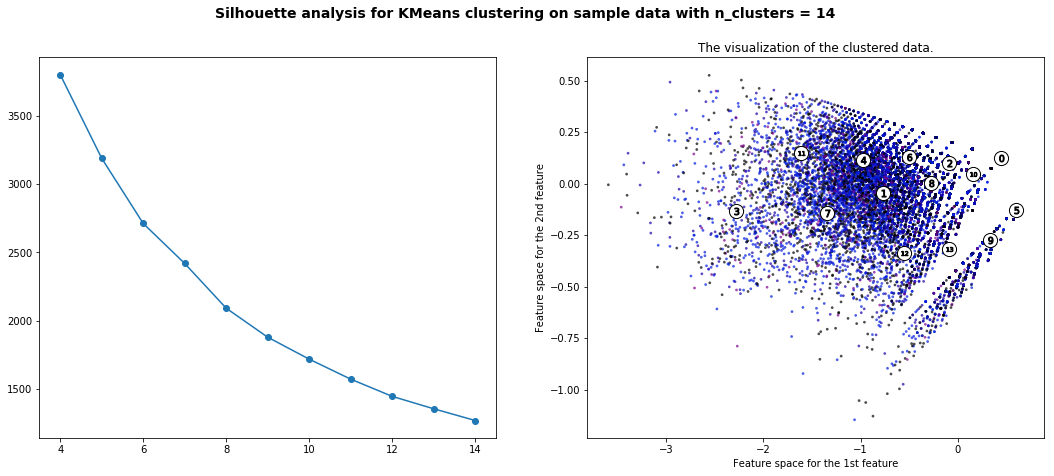

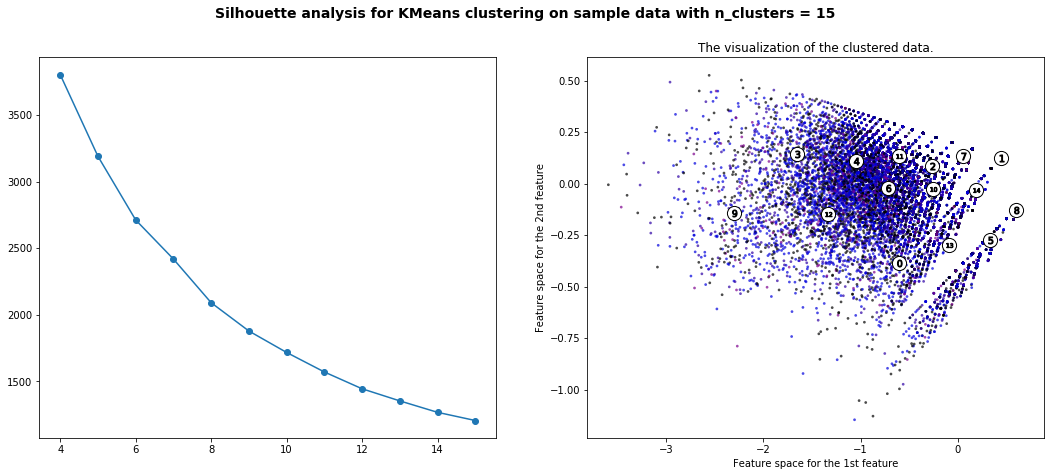

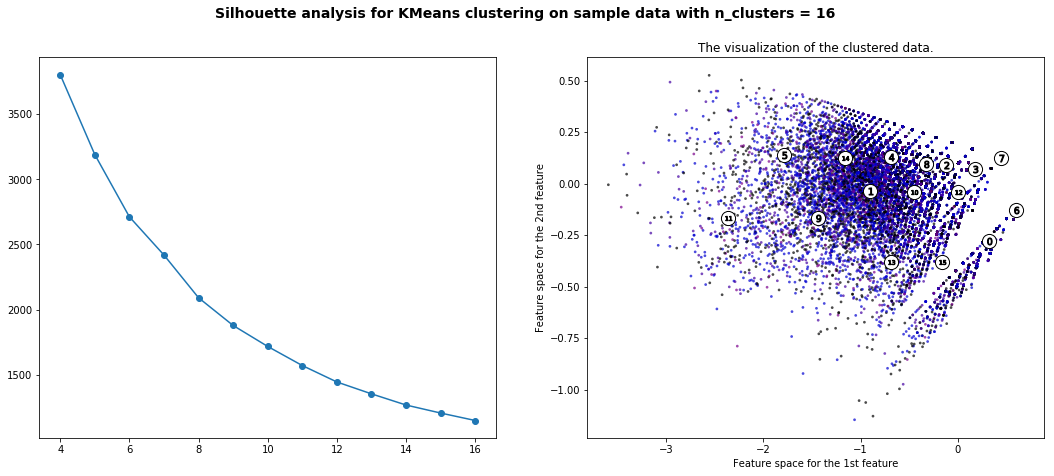

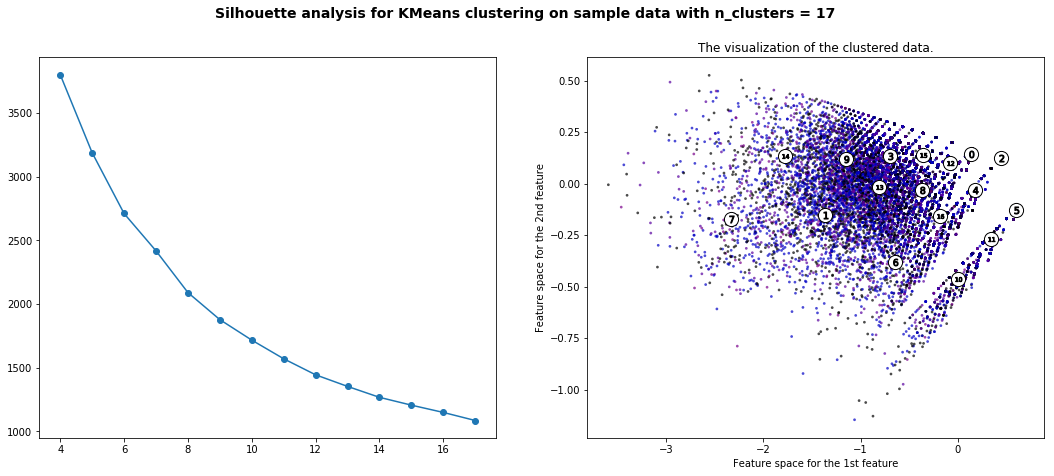

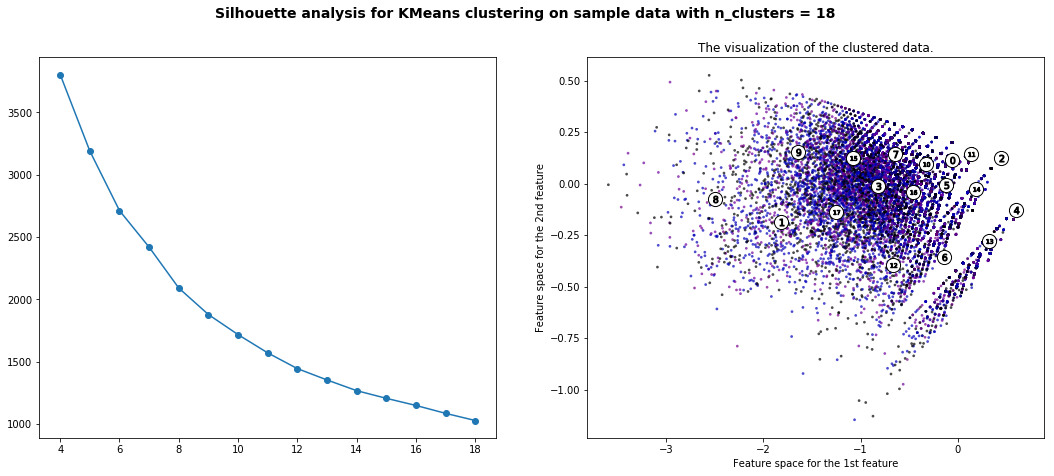

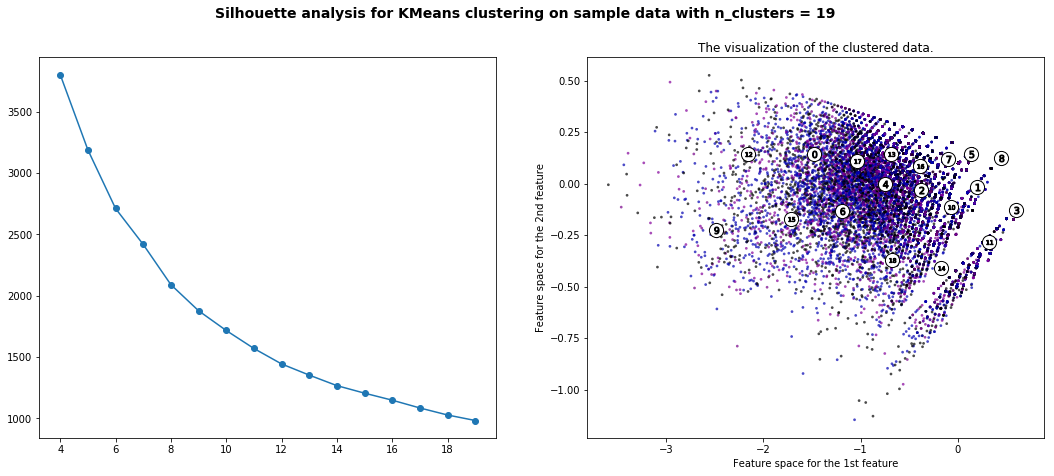

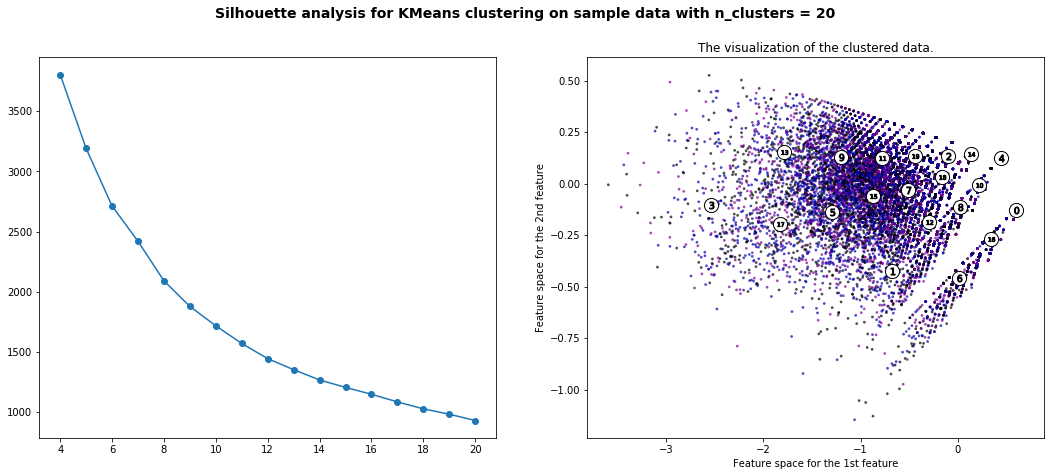

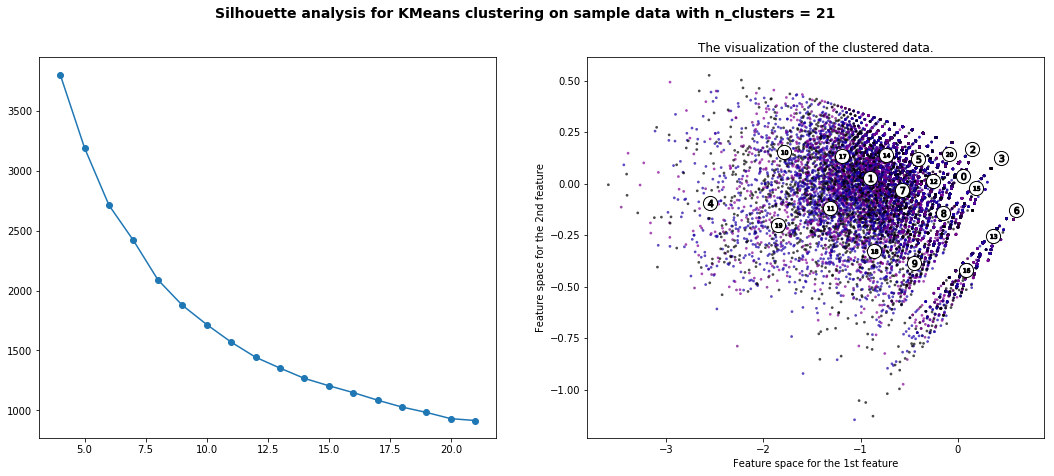

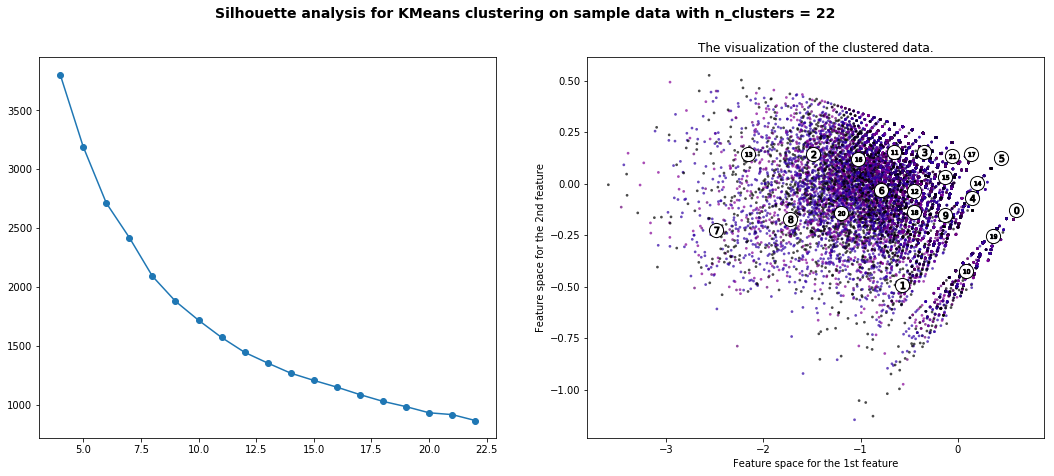

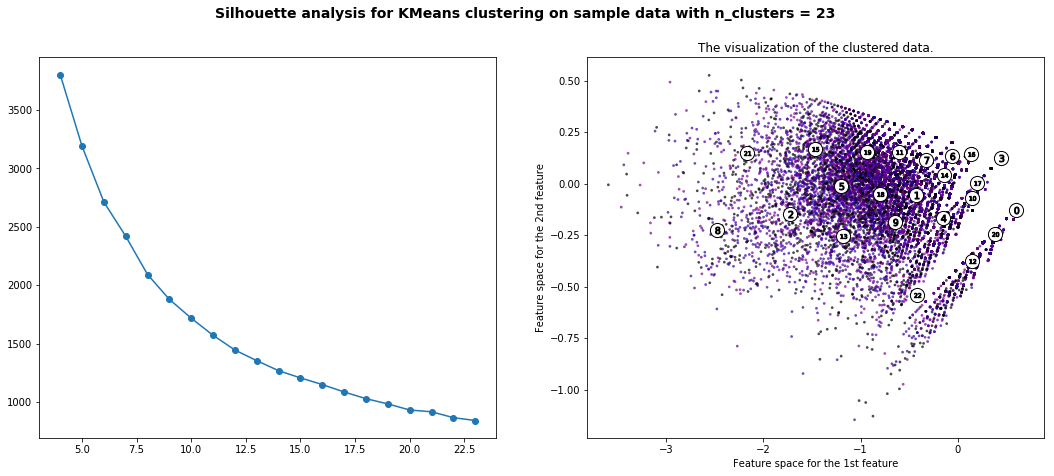

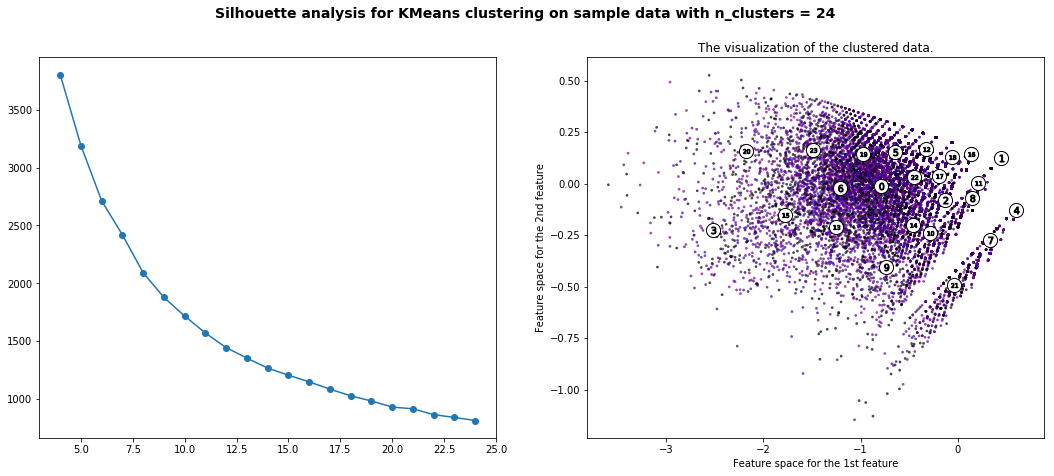

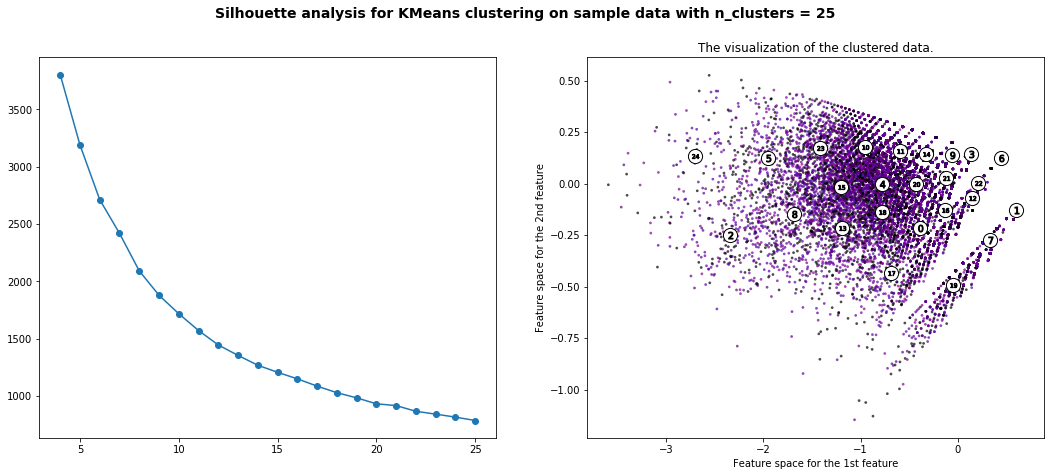

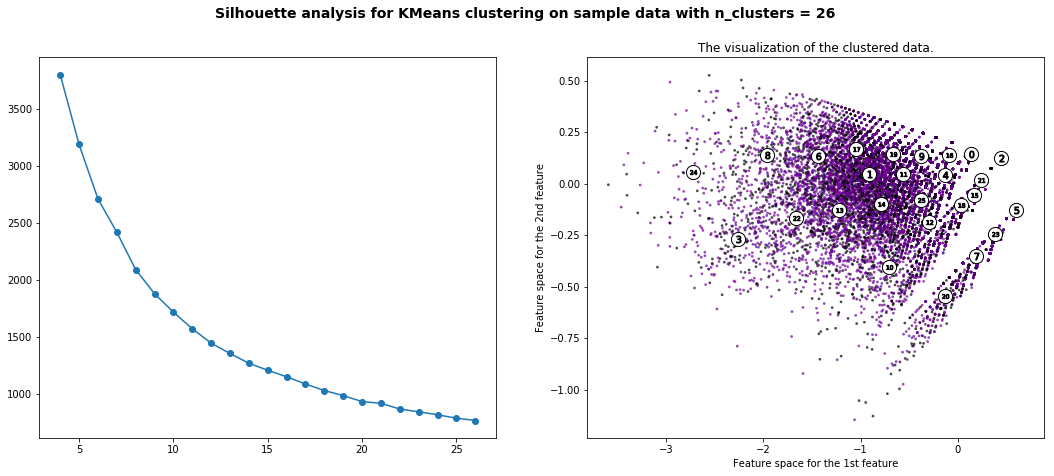

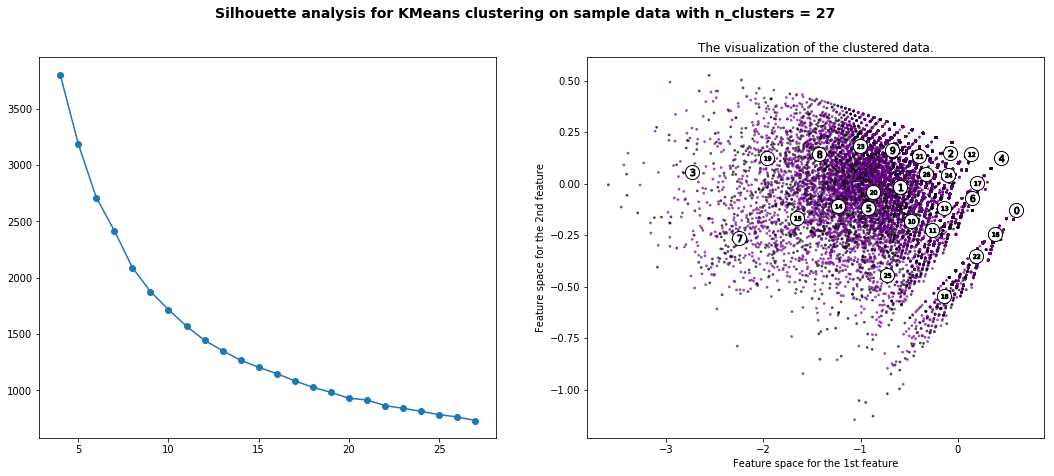

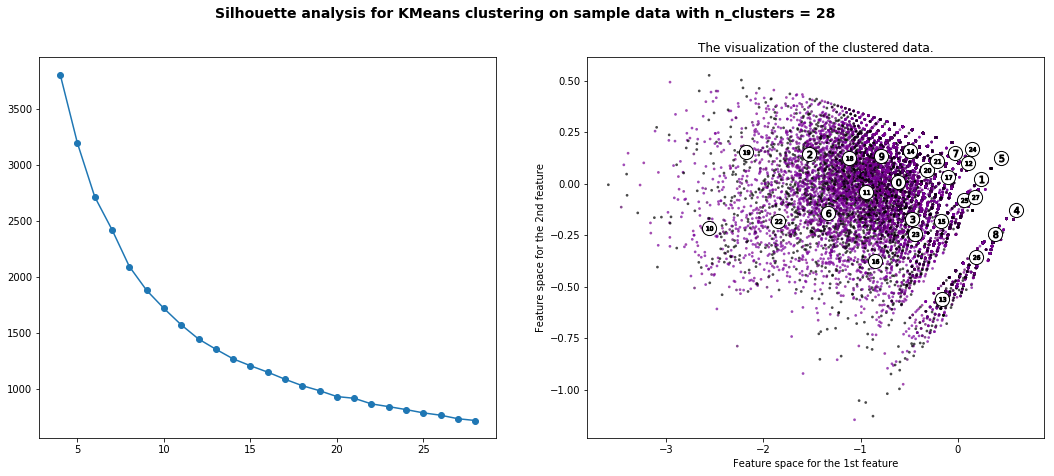

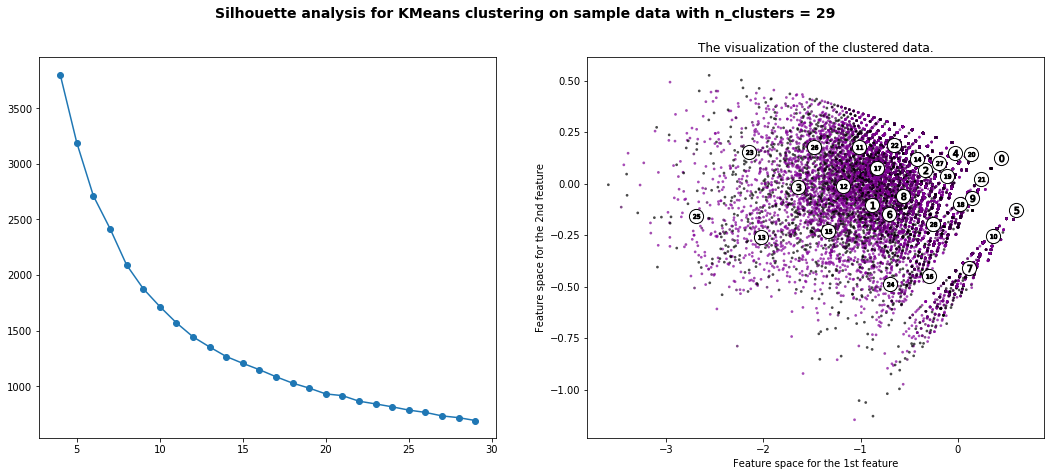

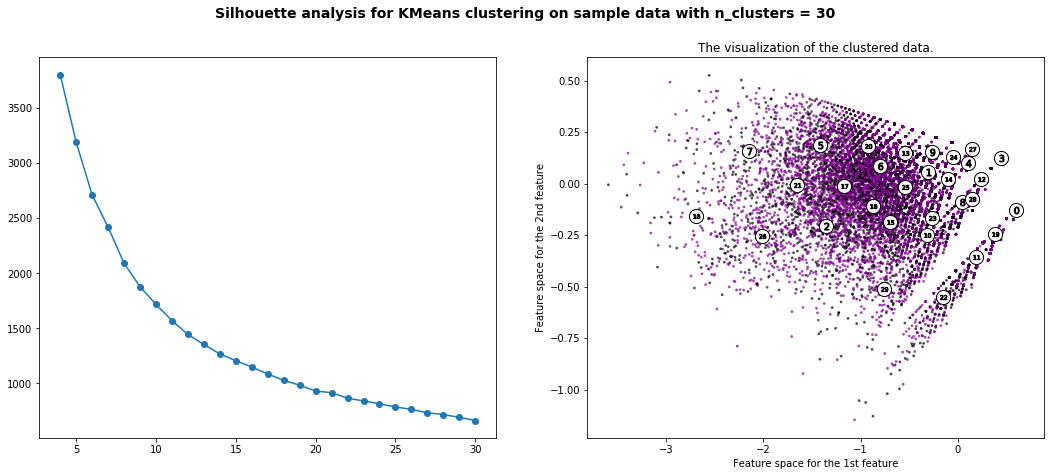

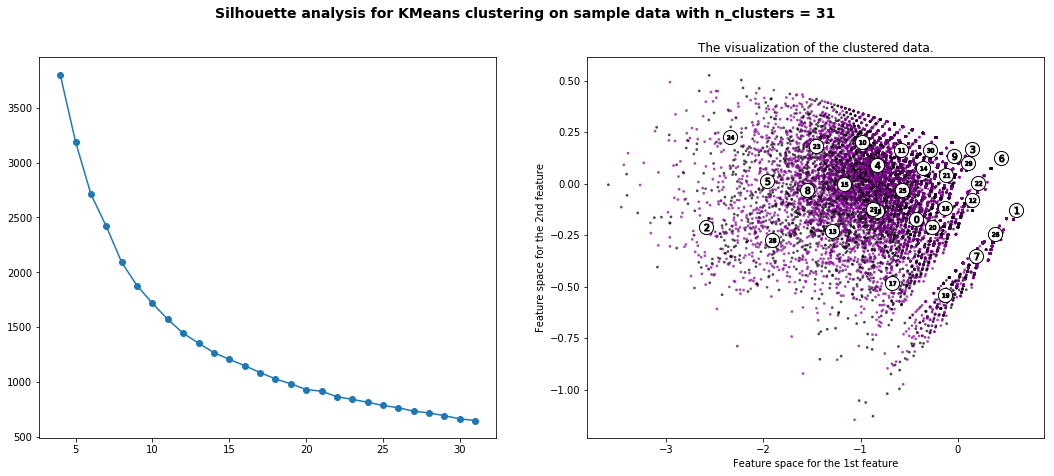

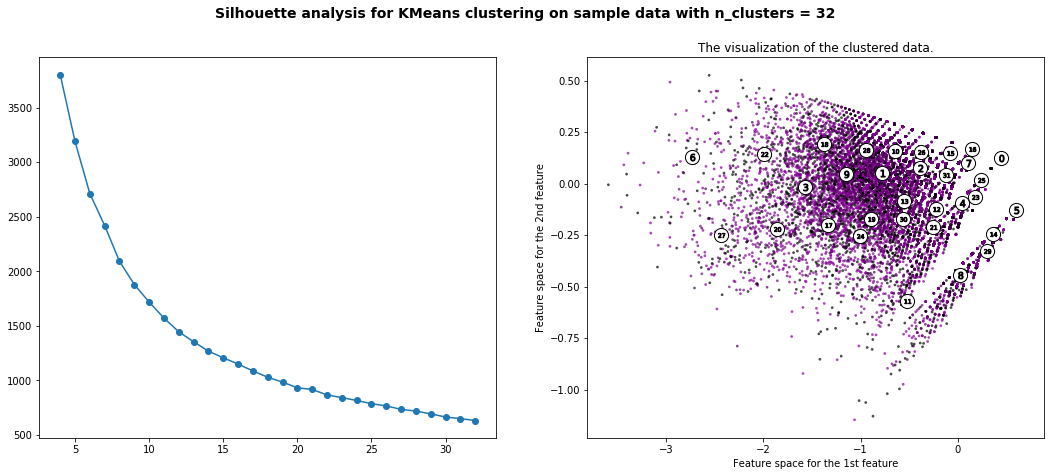

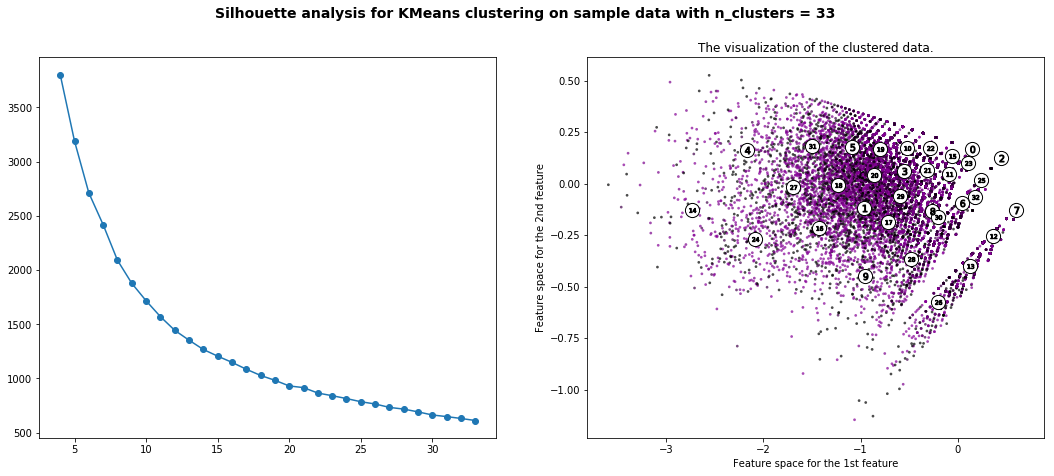

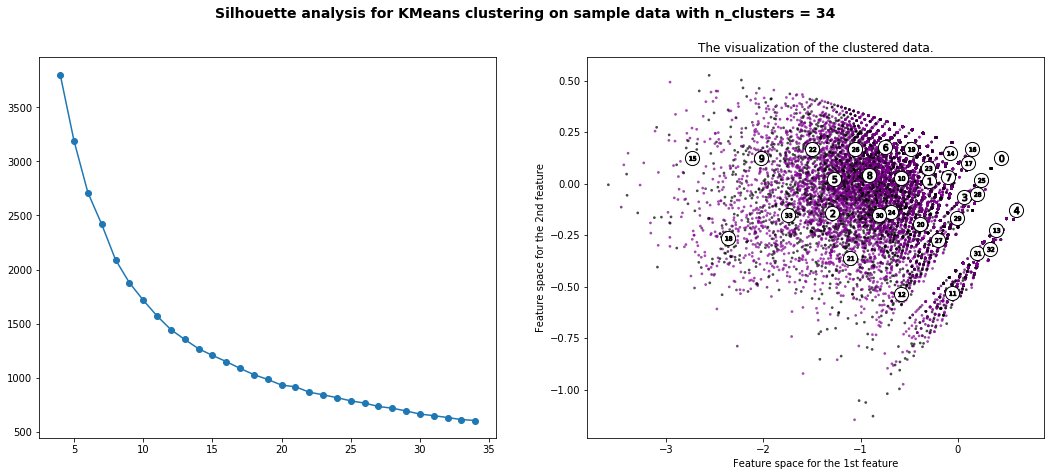

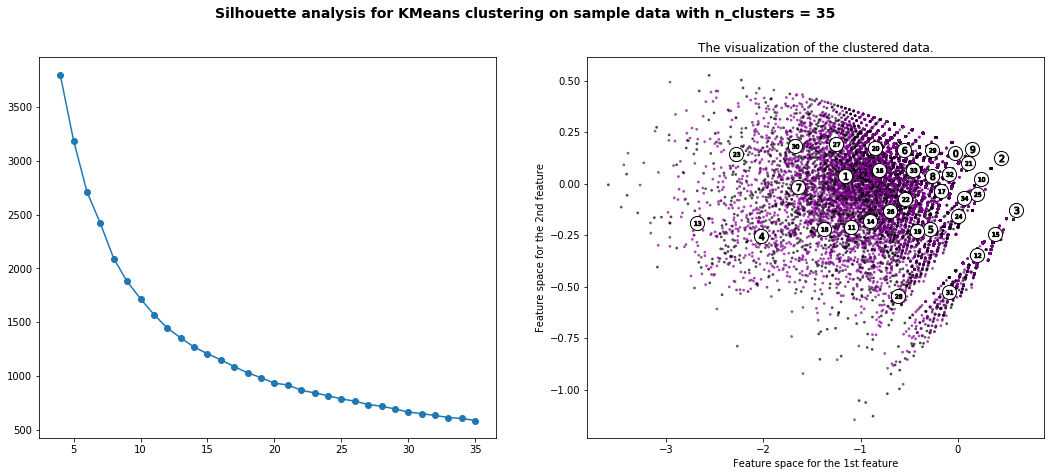

In [89]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
num_clusters = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
points = []
values = []
cluster_errors = []
cluster_numbers = []

for n_clusters in num_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer.fit_predict(intermediate_data)

    #compute the variance and plot the elbow method
    cluster_errors.append(clusterer.inertia_)
    cluster_numbers.append(n_clusters)


    #1st plot showing the scatter plot for dot products
    ax1.plot(cluster_numbers,cluster_errors, marker = "o")

    #Take the columns to plot
    X = intermediate_data.as_matrix(columns=intermediate_data.columns)
    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    


    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

('For n_clusters =', 4, 'The average silhouette_score is :', 0.4501950969229856)


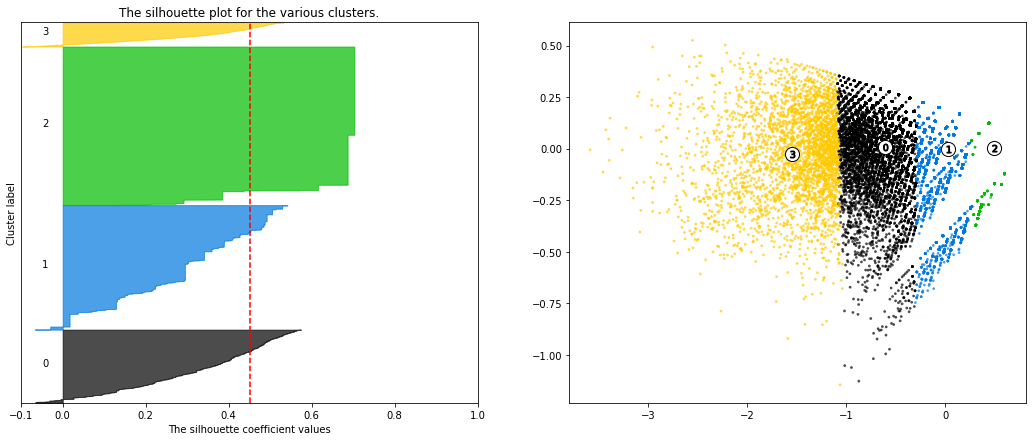

('For n_clusters =', 5, 'The average silhouette_score is :', 0.4682689907588067)


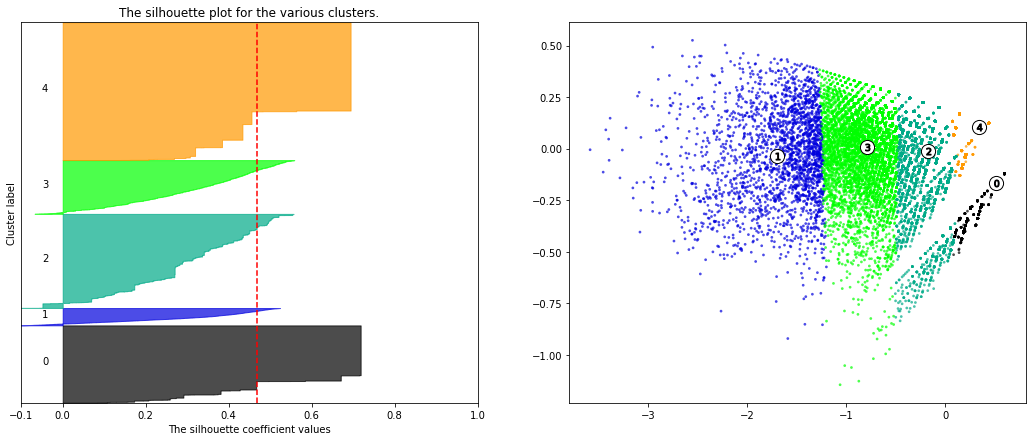

('For n_clusters =', 6, 'The average silhouette_score is :', 0.5003199150322933)


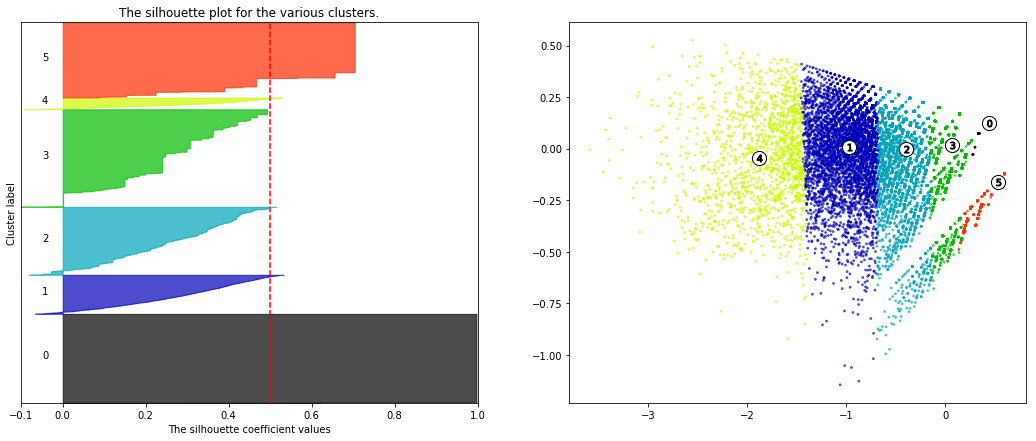

('For n_clusters =', 7, 'The average silhouette_score is :', 0.4918613344096741)


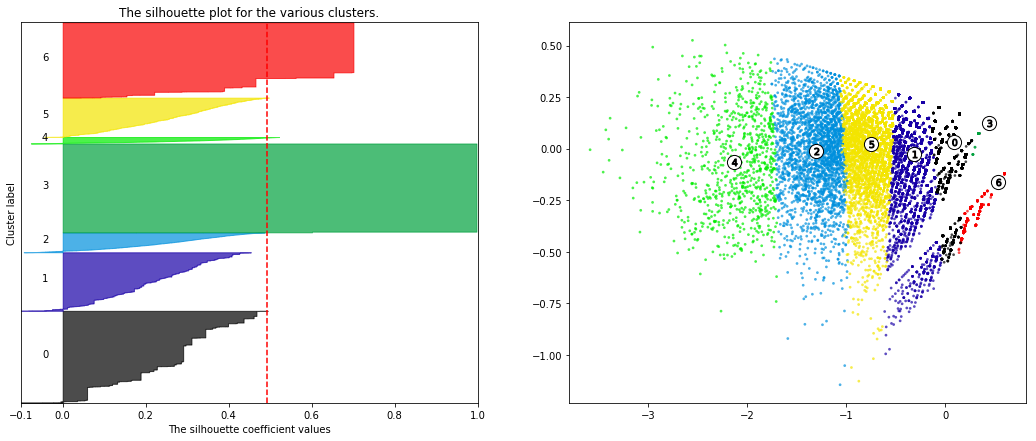

('For n_clusters =', 8, 'The average silhouette_score is :', 0.5218942551837972)


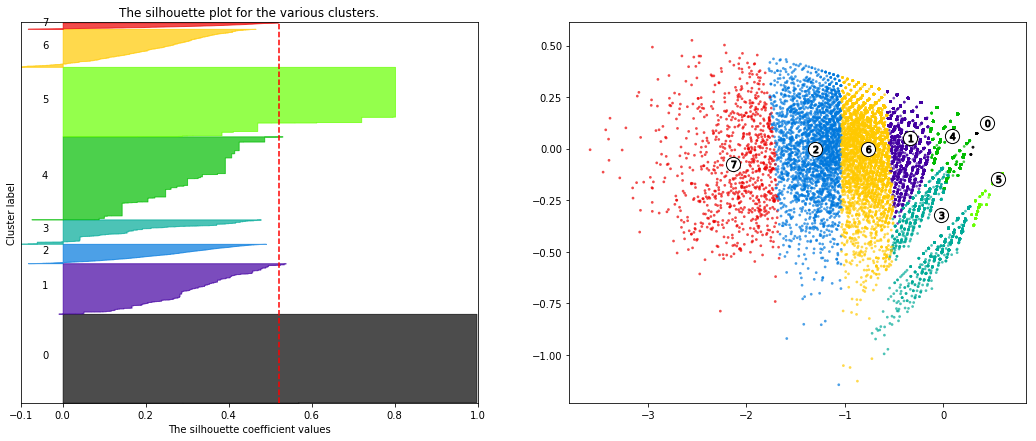

('For n_clusters =', 9, 'The average silhouette_score is :', 0.5270133100766611)


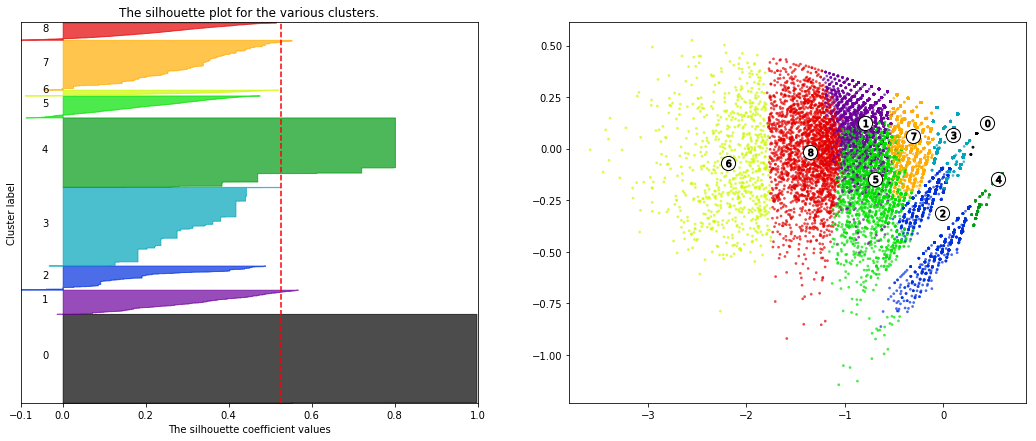

('For n_clusters =', 10, 'The average silhouette_score is :', 0.5330279272023681)


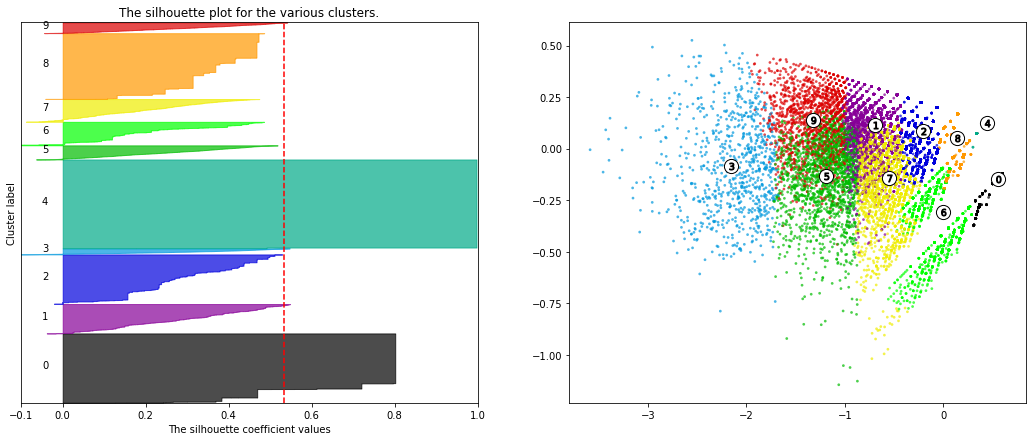

('For n_clusters =', 11, 'The average silhouette_score is :', 0.5575703102101622)


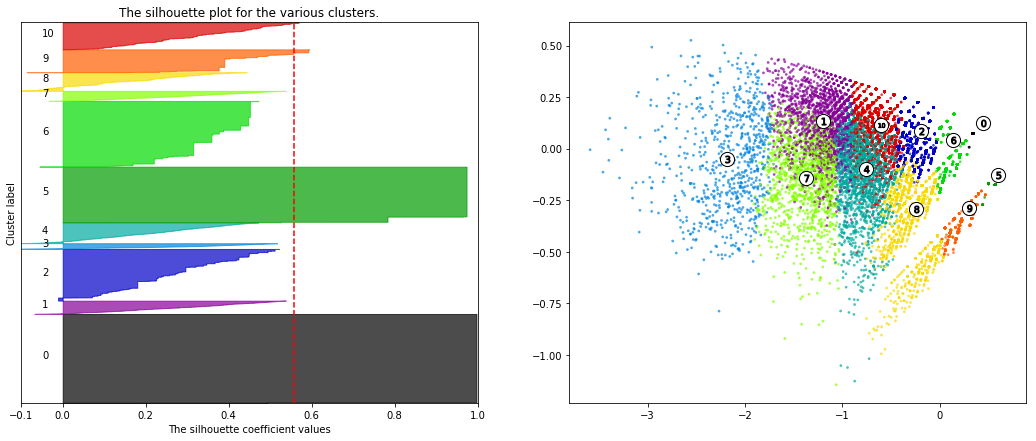

('For n_clusters =', 12, 'The average silhouette_score is :', 0.5581585325772104)


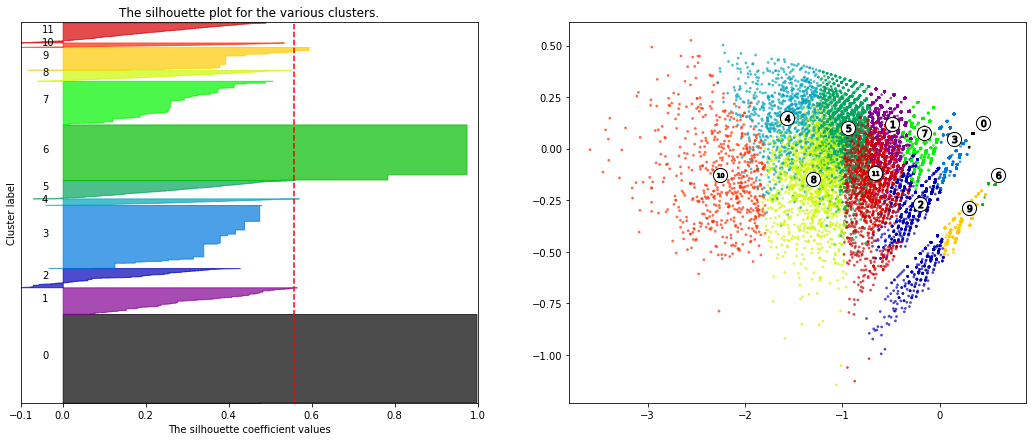

('For n_clusters =', 13, 'The average silhouette_score is :', 0.5609781207789045)


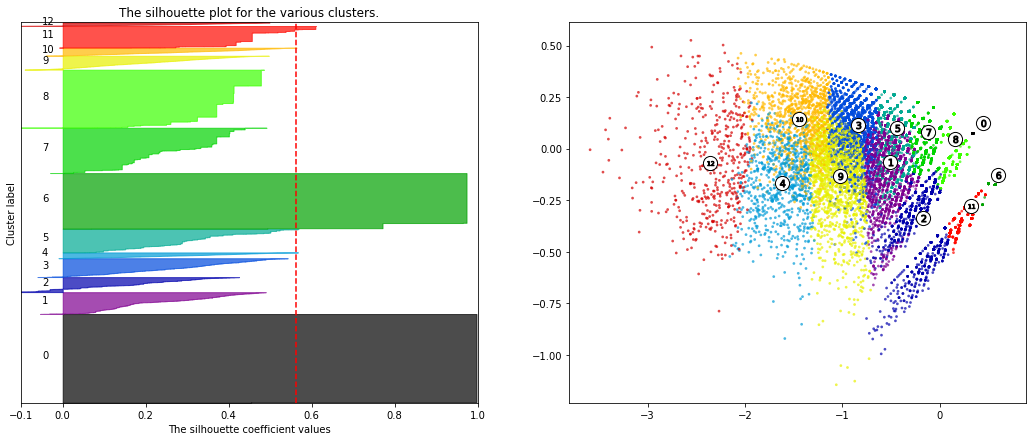

('For n_clusters =', 14, 'The average silhouette_score is :', 0.5667022494686105)


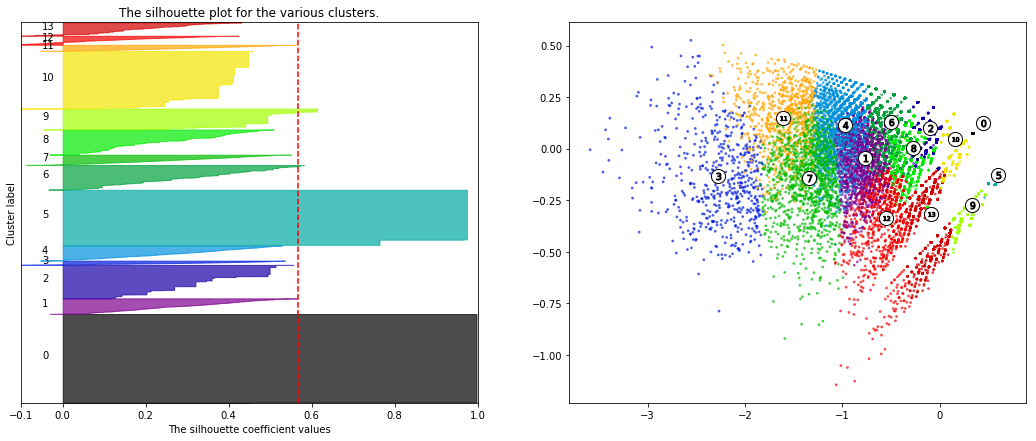

('For n_clusters =', 15, 'The average silhouette_score is :', 0.5668906172268365)


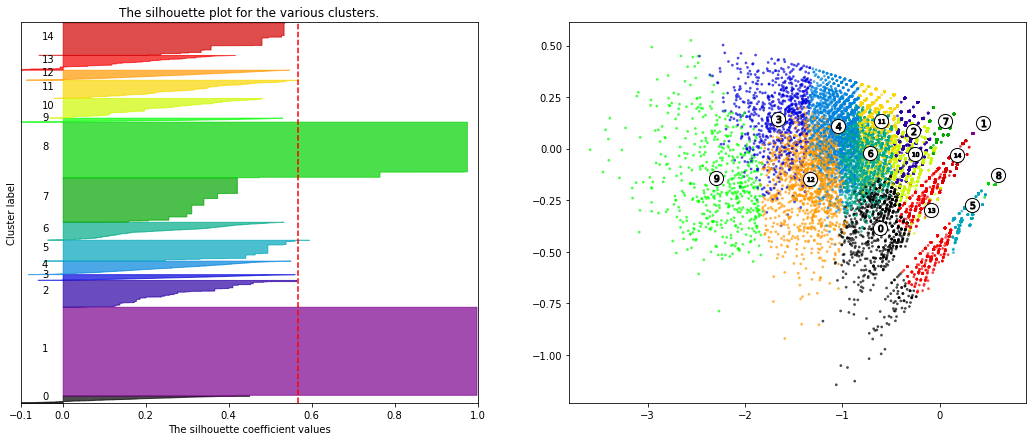

('For n_clusters =', 16, 'The average silhouette_score is :', 0.5670681098864708)


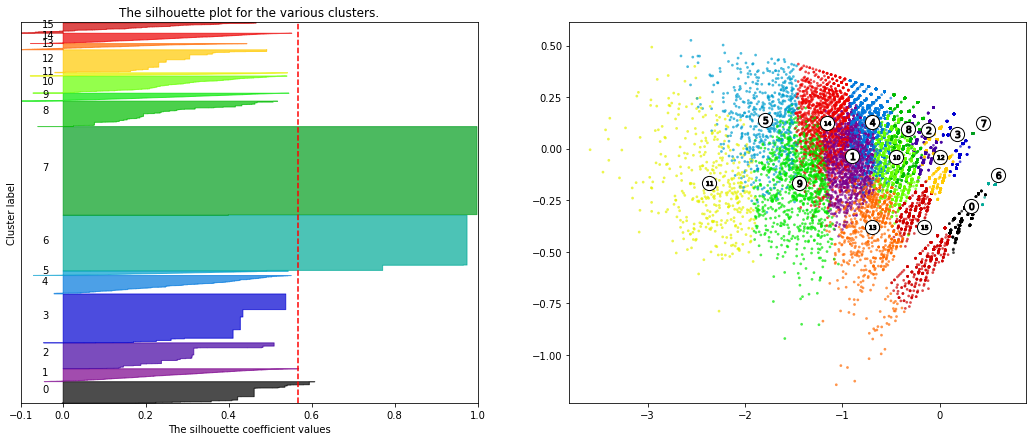

('For n_clusters =', 17, 'The average silhouette_score is :', 0.5796467328674588)


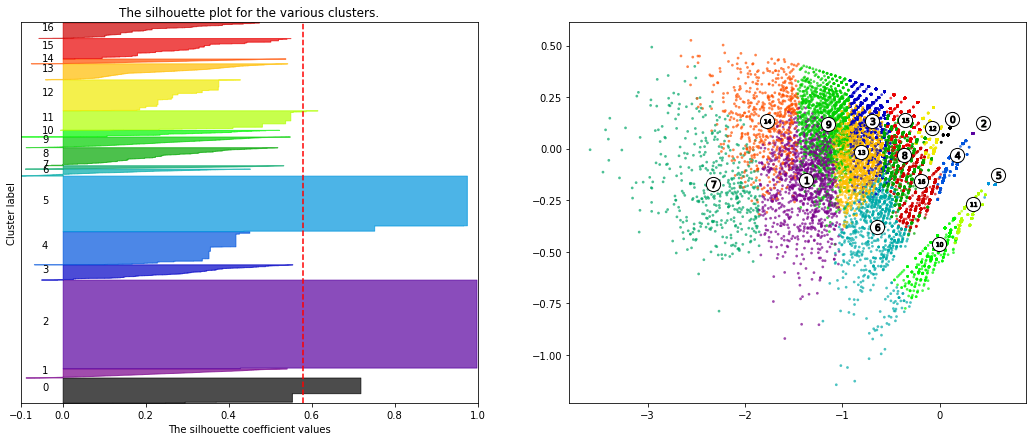

KeyboardInterrupt: 

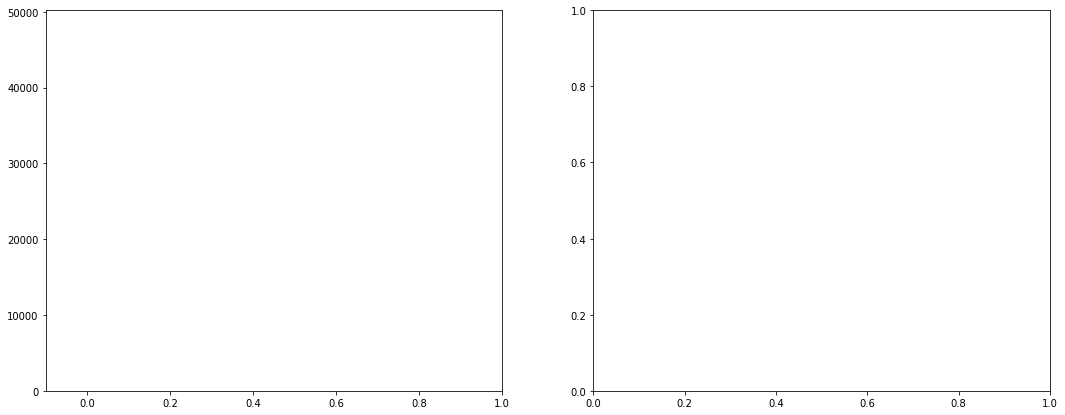

In [91]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(intermediate_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(intermediate_data)
    

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(intermediate_data,cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(intermediate_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    X = intermediate_data.as_matrix(columns=intermediate_data.columns)

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

    plt.show()